# Notebook dedicado à deteção de padrões no observavel cos(α) vs.  time residual

following: https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
file = uproot.open("/snoplus simulations/electron bulk/center point/random direction/Low Statistic/simu_Analysis_elec_10MeV.root")
file.keys()

['T;6', 'T;5', 'pmt;2', 'pmt;1']

In [4]:
data1 = file['T;6']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [5]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [6]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
mcID = np.array(data1['mcID'], dtype = np.int16)
energy = np.array(data1['energy'])
mc_position = np.array(data1['mc_position'])   #-> Position Generation
mc_momentum = np.array(data1['mc_momentum'])   #-> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

(array([1716741., 1642008., 1617226.,       0., 1501474., 1597751.,
              0., 1640561., 1664866., 1538650.]),
 array([-2.14748365e+09, -1.77167401e+09, -1.39586437e+09, -1.02005473e+09,
        -6.44245094e+08, -2.68435456e+08,  1.07374182e+08,  4.83183821e+08,
         8.58993459e+08,  1.23480310e+09,  1.61061274e+09]),
 <BarContainer object of 10 artists>)

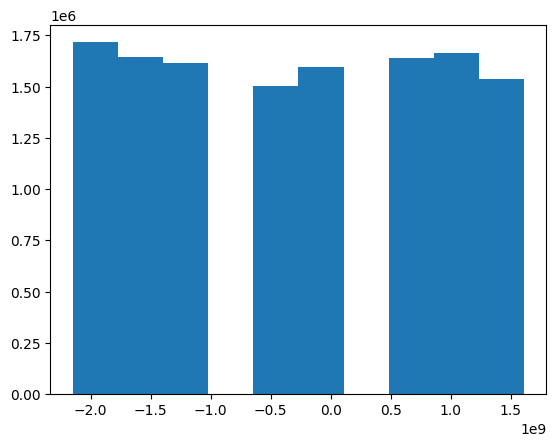

In [7]:
plt.hist(energy)

In [9]:
mc_position

array([[ 3464.75854492, -1662.61291504,  1521.85205078],
       [ 3464.75854492, -1662.61291504,  1521.85205078],
       [ 3464.75854492, -1662.61291504,  1521.85205078],
       ...,
       [-5589.40869141, -1780.72717285,  -624.14050293],
       [-5589.40869141, -1780.72717285,  -624.14050293],
       [-5589.40869141, -1780.72717285,  -624.14050293]])

## 1.2 - PMT info

In [8]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Select Data

## 2.1 - Extract  valid PMT id

In [9]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([        0,         1,         2, ..., 131016005, 131016006,
       131016007], dtype=int64)

### 2.1.1 - Extraer información valida de PMT info

In [10]:
valid_pmt_xyz = []

for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

## 2.2 - Extracción y cortes en Datos de Eventos Validos

In [234]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 10
#time cut
inf_cut = -5
up_cut = 15

#radial cut
radi_cut_method = False   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#multi_position_cut = []
#multi_mc_momentum_cut = []
multi_mc_ID_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_mc_ID.append(mcID[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        multi_position.append(position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        #multi_mc_momentum_cut.append(multi_mc_momentum[i])
        multi_mc_ID_cut.append(multi_mc_ID[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    
#multi_position_cut = np.array(multi_position_cut)
#multi_mc_momentum_cut = np.array(multi_mc_momentum_cut)
multi_mc_ID_cut = np.array(multi_mc_ID_cut, dtype = np.int16)

slipt nº: 0
In radi_cut, split nº:  0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In radi_cut, split nº:  1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In radi_cut, split nº:  2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In radi_cut, split nº:  3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In radi_cut, split nº:  4
computing cos(alpha)
doing time residual cuts
slipt nº: 5
In radi_cut, split nº:  5
computing cos(alpha)
doing time residual cuts
slipt nº: 6
In radi_cut, split nº:  6
computing cos(alpha)
doing time residual cuts
slipt nº: 7
In radi_cut, split nº:  7
computing cos(alpha)
doing time residual cuts
slipt nº: 8
In radi_cut, split nº:  8
computing cos(alpha)
doing time residual cuts
slipt nº: 9
In radi_cut, split nº:  9
computing cos(alpha)
doing time residual cuts


# 3 - Histograma 2D: time residual vs. cos(α)

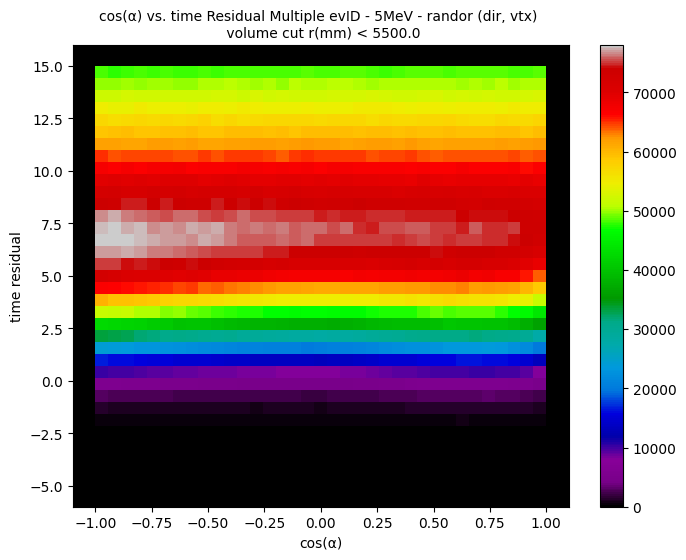

In [235]:
#%matplotlib
# 2d Histogram
bins = 35
#Titles

if radi_cut_method == True:
    title = 'cos(α) vs. time Residual Multiple evID - 5MeV - randor (dir) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    title = 'cos(α) vs. time residual - Multiple evID - 5MeV - randor (dir)'
    
ylabel = 'time residual'
xlabel = 'cos(α)'

#bins defined above when computing the Nº of PMTs in each Δα!

plt.figure(figsize=(8,6))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins], stat='count', cbar = 'True', cmap = cm.nipy_spectral, hue_norm = (0,1))
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.title(title, fontsize= 10)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
#plt.savefig('figs/High Stat/' + title+ '.png', format = 'png')
plt.show()

## 3.1 - Extraer Información de Imagen

### 3.1.1 - Imagen completa

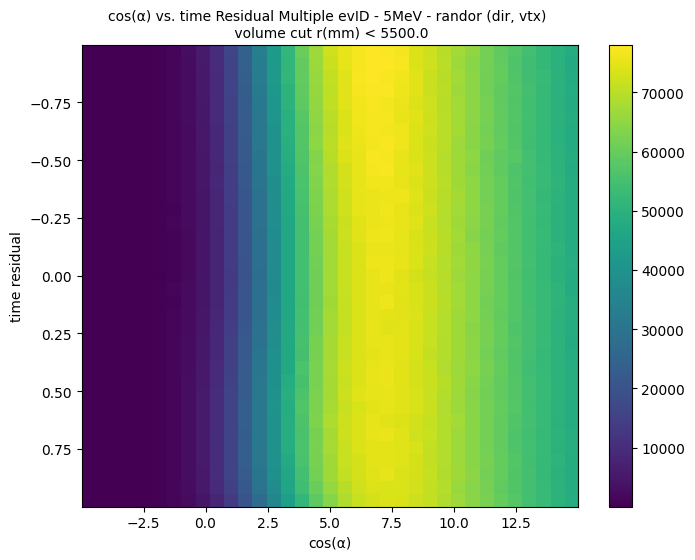

In [236]:
#Transforma Data into an Image Matrix
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

plt.figure(figsize=(8,6))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/cos(α) vs. time residual - Multiple evID - 5MeV_' + str(rad_cut_val) + '_' + str(bins) + '(imshow).png', format = 'png')

### 3.1.2 - Extraer Template

- 1 Usar Imagen normalizada

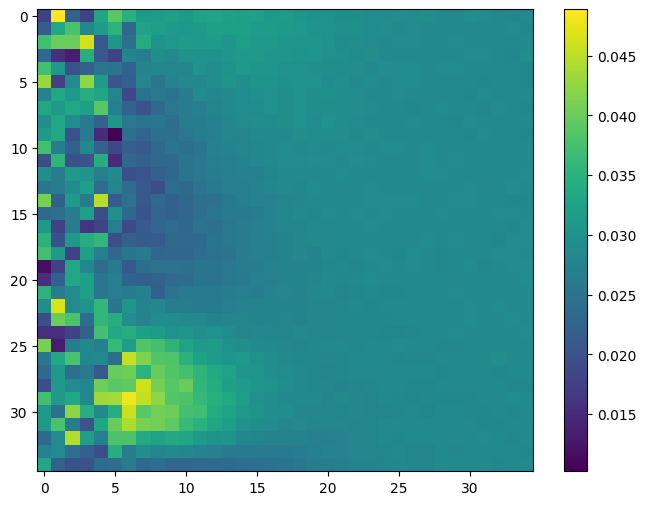

In [123]:
## sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_Hit_norm = H / sum_hit

if radi_cut_method == True:
    N1title = 'Normalization by NHits - Multiple evID - 5MeV - random (dir, vtx) \n volume cut r(mm) < '+str(rad_cut_val)

else:
    N1title = 'Normalization by NHits - Multiple evID - 5MeV - random (dir, vtx)'

plt.figure(figsize=(8,6))
plt.imshow(H_Hit_norm, aspect="auto")
#plt.imshow(H_Hit_norm, extent = [left, right, top, bottom], aspect="auto")
#plt.title(N1title, fontsize= 10)
#plt.ylabel(ylabel)
#plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/High Stat/Normalization by NHits - Multiple evID - 5MeV_' + str(rad_cut_val) + '_' + str(bins) + '(imshow).png', format = 'png')

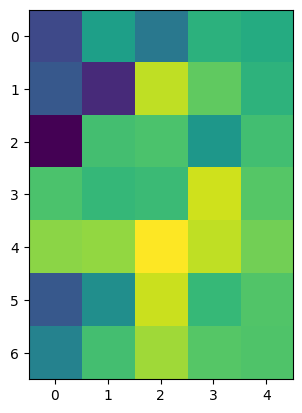

In [376]:
#define file names, directory, and decide when to save info:
sample = '5'
save = False

directory_fig_template = 'figs/High Stat/template matching/r_'+str(rad_cut_val)+'/template('+sample+').png'
directory_arr_template = 'Template Arrays/r_'+str(rad_cut_val)+'/template('+sample+').csv'
directory_fig_match = 'figs/High Stat/template matching/r_'+str(rad_cut_val)+'/matching('+sample+').png'
directory_arr_match = 'Template Arrays/r_'+str(rad_cut_val)+'/matching('+sample+').csv'

#choose region of template
H_template = H_Hit_norm[25:32, 4:9]  
plt.imshow(H_template)

if save:
    plt.savefig(directory_fig_template , format = 'png')
    np.savetxt(directory_arr_template, H_template, delimiter = ',')

#Registros interesante en cortes del template:
#r<5500:
#[25:35, 3:8] (1) - Se observa pico en ROI
#[24:34, 3:10](2) - no se observa pico en ROI
#[23:35, 3:7] (3)  - Se observa ROI
#[25:35, 5:8] Se observa pico en ROI
#[25:33, 5:7] se observa pico en ROI

#r<4500:
#[24:34, 3:10](1) - No se ve pico en ROI
#[23:35, 3:11](2) - no se observa pico en ROI
#[24:35, 4:10](3) - Se observa ligeramente ROI
#[23:35, 4:9](4) - se observa mejor ROI

#r<3500:
#[25:33, 4:12](1) No se observa pico en ROI
#[24:34, 5:12](2) No se observa pico en ROI
#[23:35, 4:8](3) Se observa pico en ROI
#[24:35, 5:8](4) Se observa pico en ROI
#[24:34, 5:8](5) se observa pico en ROI
#[24:35, 4:10](6) se observa pico en ROI
#[25:33, 5:9](7) se observa pico e ROI

### 3.2.2 - Tratar Template Matching Method

In [377]:
#normalize data before match.Template method
H_norm = cv.normalize(H, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
H_template_norm = cv.normalize(H_template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)

#rescaling images after normlazitaion -> necessary to be accepte by match.template()!
H_T = H_norm.astype(np.uint8) #Ideal: np.uint16
H_template_T = H_template_norm.astype(np.uint8)  #Ideal: np.float16

In [378]:
# Choose method
method = eval('cv.TM_CCOEFF')

#Apply template matching
match_res = cv.matchTemplate(H_T, H_template_T, method)

# obtain the maximum value
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)  #obtain maximun and minimun values and location of array

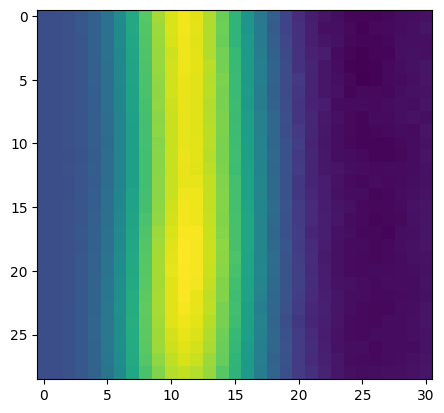

In [379]:
plt.imshow(match_res)
if save:
    plt.savefig(directory_fig_match , format = 'png')
    np.savetxt(directory_arr_match, match_res, delimiter = ',')

In [342]:
min_loc

(26, 5)

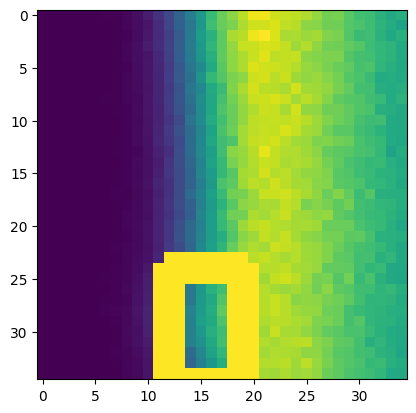

In [69]:
# Localizar donde esta el maximo en la imagen usando un rectangulo

h, w = np.shape(H_template_T)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

ROI_ident = cv.rectangle(H_T, top_left, bottom_right, color = 255, thickness = 2)

plt.imshow(ROI_ident)